In [ ]:
# Uncomment to install the required packages
# !pip install git+https://github.com/fagonzalezo/kdm.git

In [34]:
import numpy as np
from scipy.stats import norm
from scipy.stats import gaussian_kde

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import optimizers
from keras import losses
from keras import metrics
from keras.callbacks import ModelCheckpoint


from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from kdm.models import KDMDenEstModel, KDMClassModel, KDMJointDenEstModel
import kdm 

from tqdm import tqdm

import matplotlib.pyplot as plt

# An Introduction to Kernel Density Matrices

A kernel density matrix is a formalism to represent marginal and joint probability distributions of discrete and continuous variables. It has an associated inference process that is differentiable and, therefore, integrable with deep learning models. It is was introduced in the paper [Kernel Density Matrices for Probabilistic Deep Learning
](https://arxiv.org/abs/2305.18204). An implementation is available at: https://github.com/fagonzalezo/kdm. 

Before we dive into the details of kernel density matrices, let's first understand the concept of kernel density estimation.

## 1. Kernel Density Estimation

### 1.1. Definition and example

Kernel density estimation is a non-parametric method to estimate the probability density function of a random variable. Given a set of $n$ samples $x_1, x_2, \ldots, x_n$ from a random variable $X$, the kernel density estimate of the probability density function of $X$ is given by:

$$
\hat{f}(x) = \frac{1}{n} \sum_{i=1}^n K_h(x, x_i)
$$

where $K_h$ is a kernel function and $h$ is the bandwidth parameter. The kernel function is a non-negative function that integrates to one. The most common kernel functions is the Gaussian kernel:

$$
k_{\mathrm{rbf}, \sigma}( {x}, {y}) = \frac{1}{\mathcal{M}_{k_\text{rbf}}}e^{\frac{-|| {x} -  {y}||^2}{2\sigma^2}}
$$

where $\sigma$ is the bandwidth parameter and $\mathcal{M}_{k_\text{rbf}}=\frac{1}{\sqrt{(2\pi)^m}(\sqrt{2}\sigma)^m}$ is a normalization constant. The bandwidth parameter $\sigma$ controls the smoothness of the kernel density estimate. 

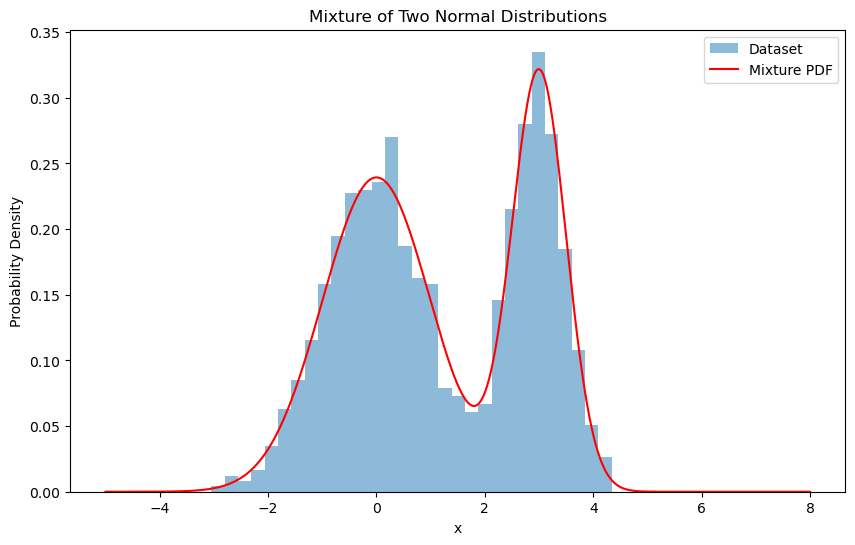

In [2]:
# Set the random seed for reproducibility
np.random.seed(0)

# Parameters for the mixture of two normal distributions
mu1 = 0
sigma1 = 1
mu2 = 3
sigma2 = 0.5
weight1 = 0.6
weight2 = 0.4

# Generate the dataset
n_samples = 2000
samples1 = np.random.normal(mu1, sigma1, int(n_samples * weight1))
samples2 = np.random.normal(mu2, sigma2, int(n_samples * weight2))
dataset = np.concatenate((samples1, samples2))
dataset = np.random.permutation(dataset)

# Calculate the PDF of the mixture
def mixture_pdf(x):
    return weight1 * norm.pdf(x, mu1, sigma1) + weight2 * norm.pdf(x, mu2, sigma2)

x = np.linspace(-5, 8, 1000)
pdf_mixture = mixture_pdf(x)

# Plot the dataset and the PDF of the mixture
plt.figure(figsize=(10, 6))
plt.hist(dataset, bins=30, density=True, alpha=0.5, label='Dataset')
plt.plot(x, pdf_mixture, color='red', label='Mixture PDF')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Mixture of Two Normal Distributions')
plt.legend()
plt.show()

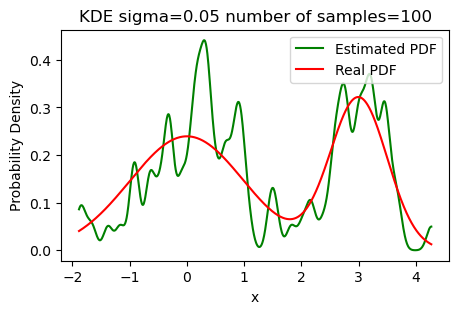

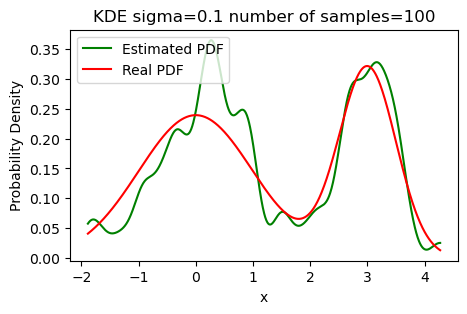

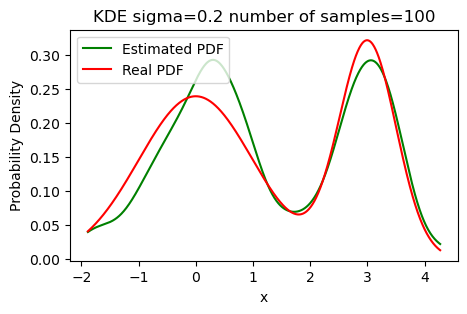

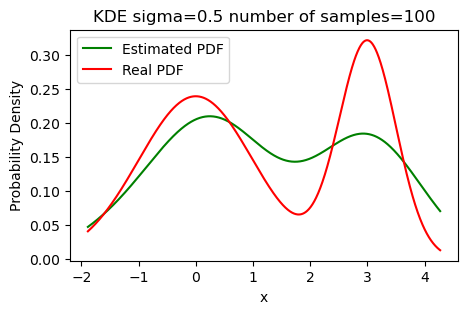

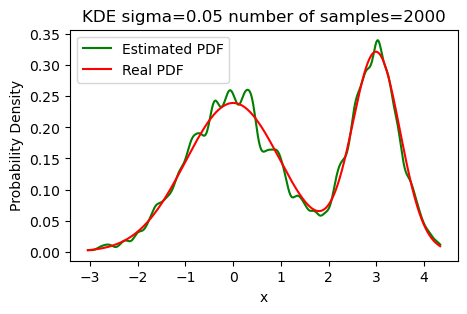

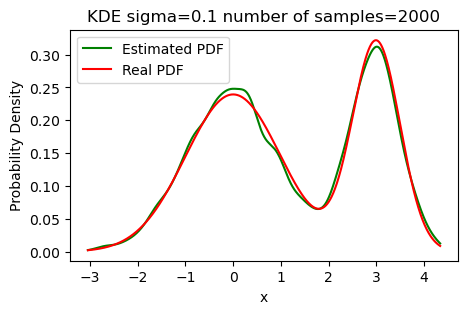

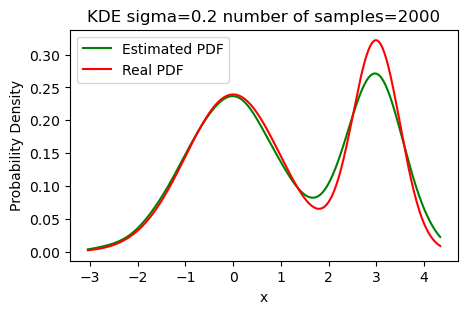

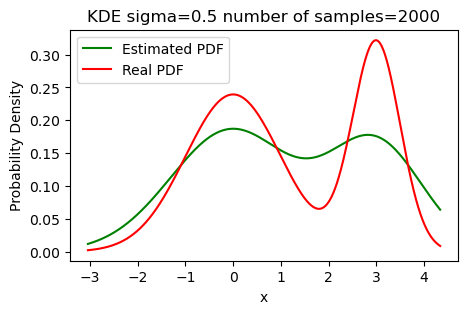

In [3]:
def kde_plot(dataset, sigma, real_pdf):
    # Apply KDE to the sample
    kde = gaussian_kde(dataset, bw_method=sigma)

    # Estimate the PDF
    min_x = np.min(dataset)
    max_x = np.max(dataset) 
    x = np.linspace(min_x, max_x, 1000)
    pdf_estimate = kde.evaluate(x)
    pdf_real = real_pdf(x)
    # Plot the dataset and the estimated PDF
    plt.figure(figsize=(5, 3))
    plt.plot(x, pdf_estimate, color='green', label='Estimated PDF')
    plt.plot(x, pdf_real, color='red', label='Real PDF')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.title(f'KDE sigma={sigma} number of samples={len(dataset)}')
    plt.legend()
    plt.show()

for sigma in [0.05, 0.1, 0.2, 0.5]:
    kde_plot(dataset[:100], sigma, mixture_pdf)

for sigma in [0.05, 0.1, 0.2, 0.5]:
    kde_plot(dataset, sigma, mixture_pdf)


## 1.2 Extensions to Kernel Density Estimation


### 1.2.1 Kernel Density Classification

Given a set of samples $\{x_1, x_2, \ldots, x_n\}$ from a random variable $X$ and a set of labels $\{y_1, y_2, \ldots, y_n\}$, the kernel density estimate of the probability density function of $X$ conditioned on $Y$ is given by:

$$
\hat{f}(x|y) = \frac{1}{\sum_{i=1}^n \delta(y, y_i) } \sum_{i=1}^n K_h(x, x_i) \delta(y, y_i)
$$

where $\delta(y, y_i)$ is the Kronecker delta function. This pdf can be used to classify new samples $x$ by computing the posterior probability of each class $y$ given $x$:

$$
p(y|x) = \frac{\hat{f}(x|y) p(y)}{\sum_{y'} \hat{f}(x|y') p(y')}
$$

### 1.2.2 Nadaraya-Watson kernel regression
Given a set of samples $\{x_1, x_2, \ldots, x_n\}$ from a random variable $X$ and a set of labels $\{y_1, y_2, \ldots, y_n\}$, the kernel density estimate of the conditional expectation of $Y$ given $X$ is given by:

$$
E[y|x] \approx \hat{f}(y|x) = \frac{\sum_{i=1}^n K_h(x, x_i) y_i}{\sum_{i=1}^n K_h(x, x_i)}
$$

## 1.3 KDE problems

* KDE is a memory-based method that requires to store all the samples in memory.
* Estimation of the bandwidth parameter is a difficult problem.
* Dealing with high-dimensional data is challenging.
* It is not clear how to model Joint probability distributions of discrete and continuous variables.
* KDE is not differentiable, which makes it difficult to integrate with deep learning models.

## 2. Kernel Density Matrices

A kernel density matrix (KDM) over a set $\mathbb{X}$ is a triplet:
$$
\rho = ( {C}, {p},k_\theta)
$$
where 

$ {C}=\{ {x}^{(1)},\dots, {x}^{(m)}\}\subseteq \mathbb{X}$, 

$ {p}=(p_1,\dots,p_m) \in \mathbb{R}^m$, with  $p_i\ge 0$ and $\sum_{i=1}^n p_i = 1$, and 

$k_{\theta}:\mathbb{X} \times \mathbb{X}\rightarrow\mathbb{R}$, such that $\forall  {x}\in\mathbb{X}, \ k( {x}, {x})=1$.

The projection function associated to a KDM $\rho$  is defined as:

\begin{equation}
    f_{\rho}( {x})=\sum_{ {x}^{(i)} \in  {C}} p_i k_\theta^2( {x}, {x}^{(i)}) 
\end{equation}

The projection function $f_{\rho}$ can be transformed in a probability density function (PDF) by multiplying it by a normalization constant that depends on the kernel of the KDM:

\begin{equation}
    \hat{f}_{\rho}( {x})=\mathcal{M}_k
    f_{\rho}( {x})  \tag{2}
\end{equation}




## 2.1 Discrete KDMs

Given $\mathbb X = \mathbb R ^n$, a KDM with the cosine kernel: 
$$
    k_\mathrm{cos}( {x},  {y}) = \frac{< {x},  {y}>}{\sqrt{< {x},  {x}>< {y},  {y}>}}
$$
represents a discrete probability distributions on a finite event space with $n$ elements. The 
normalization constant for this kernel is $\mathcal{M}_{k_\text{cos}} = 1$.

As an example, consider the discrete probability distribution
$$
 {p} = (0.2, 0.3, 0.5)
$$
It  can be represented by the KDM 
$$
\rho_0 = (\{(1, 0, 0), (0, 1, 0), (0, 0, 1)\},(0.2, 0.3, 0.5), k_\mathrm{cos})
$$  
also, it can be represented by the KDM 
$$
\rho_1 = (\{(\sqrt{0.2}, -\sqrt{0.3}, \sqrt{0.5})\},(1), k_\mathrm{cos})
$$

To compute the probability of an event, we use the projection function (Eq. 1). For instance, the probability of the event $(0, 1, 0)$ is given by:

$$
f_{\rho_1}((0, 1, 0)) =(k_\mathrm{cos}((0, 1, 0), (\sqrt{0.2}, -\sqrt{0.3}, \sqrt{0.5})))^2 = (-\sqrt{0.3})^2 = 0.3
$$

**_Note_**: The fact that we can use negative values as the components of the KDM is a consequence of the definition of the projection function (Eq. 1) as the square of the kernel. This is closely related to quantum probability, where probabilities are represented by complex amplitudes. In fact KDMs correspond to a kernelized version of density matrices in quantum mechanics.

## 2.2 Continuous KDMs
A KDM 
$$
\rho_\mathbf{x}=( {C}, {p},k_\mathrm{rbf})
$$ 

with 
$  C \subseteq \mathbb{R}^n$ and

$$
k_\mathrm{rbf}( {x}, {y}) = e^{\frac{-|| {x} -  {y}||^2}{2\sigma^2}}
$$

represents a continuous probability distribution of a random variable $\mathbf{x} \in \mathbb{R}^n$ with a PDF given by Eq. 2  with normalizing constant  $\mathcal{M}_{k_\text{rbf}}=\frac{1}{\sqrt{(2\pi)^n}(\sqrt{2}\sigma)^n}$. This can be seen as a generalization of KDE where the samples can have different weights.



## 2.3 Density estimation with KDMs

Since a KDM extends the notion of kernel density estimator, it is possible to perform non-parametric density estimation with KDMs. If we define a KDM with the dataset as the components $  C$ each one with an associated probability $p_i = \frac{1}{n}$ and an RBF kernel with parameter $\sigma$, Eq. 2  corresponds to a KDE density estimator with a Gaussian kernel and a bandwidth parameter $\sqrt{2}\sigma$.

It is also possible to perform parametric density estimation by maximizing the likelihood of the KDM parameters given a training dataset. Given a KDM with $K$ components $\rho=( {C}=\{ {c}^{(1)},\dots, {c}^{(K)}\}, {p}=\{p_1,\dots,p_K\},k_{\theta})$, where $\theta$ indicate a set of parameters of the kernel, and a training data set $ {D}=\{ {x}_1, \dots,  {x}_\ell\}$, solving the following optimization problem:
\begin{equation}
    \max_{ {C},  {p},\theta} \sum_{i=1}^\ell \log \hat{f}_\rho(x_i) \tag{3}
\end{equation}
will find a KDM that maximizes the probability density of the samples in $ {D}$. For the cosine or RBF kernels this is equivalent to perform maximum likelihood estimation.

We can illustrate the use of KDMs for density estimation using the dataset we created in section 1.1.

In [4]:
def kdm_plot(dataset, kdm, real_pdf):
    min_x = np.min(dataset)
    max_x = np.max(dataset) 
    x = np.linspace(min_x, max_x, 1000)
    x = x[:, None]
    kdm_distrib = kdm.get_distrib()
    pdf_estimate = np.exp(kdm_distrib.log_prob(x))
    pdf_real = real_pdf(x)
    components = kdm.kdmproj.c_x.numpy()
    weights = keras.ops.abs(kdm.kdmproj.c_w).numpy()
    weights /= np.sum(weights)
    # Plot the dataset and the estimated PDF
    plt.figure(figsize=(5, 3))
    plt.plot(x, pdf_estimate, color='green', label='Estimated PDF')
    plt.plot(x, pdf_real, color='red', label='Real PDF')
    plt.scatter(components, np.zeros_like(components), marker='x')
    # plot a vertical line for each component with length equal to the weight of the component
    for i in range(len(components)):
        plt.plot([components[i], components[i]], [0, weights[i]], color='black')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    sigma = kdm.kernel.sigma.numpy()
    plt.title(f'KDM sigma={sigma:.3f} number of components={len(components)}')
    plt.legend(loc='upper left')
    plt.show()

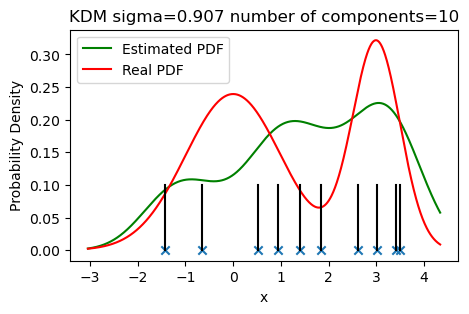

100%|██████████| 200/200 [00:26<00:00,  7.51it/s]


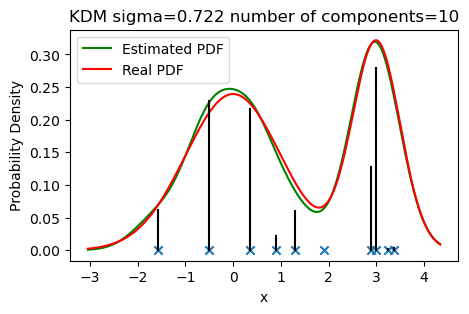

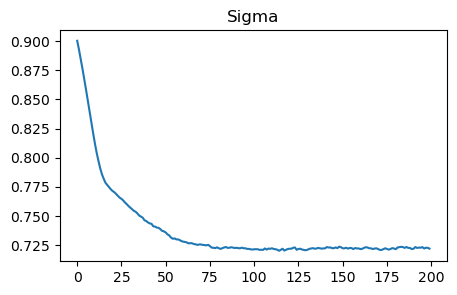

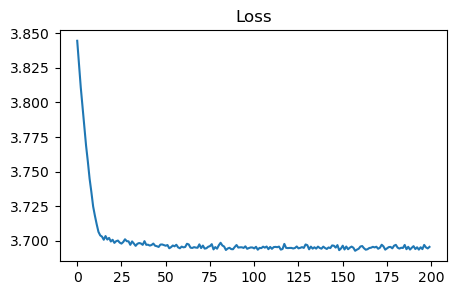

In [5]:
train_dataset = dataset[:, None]

n_comp = 10 # Number of components of the KDM

kdmdensity = KDMDenEstModel(
                            dim_x=1,
                            sigma=0.1,
                            n_comp=n_comp)

# Initialize the KDM components from the dataset
idx = np.random.randint(train_dataset.shape[0], size=n_comp)
kdmdensity.init_components(train_dataset[idx], init_sigma=True, sigma_mult=0.5)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
kdmdensity.compile(optimizer=optimizer)

kdm_plot(train_dataset, kdmdensity, mixture_pdf)
# Train the KDM density model
sigmas = []
losses = []
epochs = 200
for i in tqdm(range(epochs)):
    history = kdmdensity.fit(train_dataset,
                    epochs=1, batch_size=256, verbose=0, shuffle=True)
    sigmas.append(kdmdensity.kdmproj.kernel.sigma.numpy())
    losses.append(history.history['loss'][0])

kdm_plot(train_dataset, kdmdensity, mixture_pdf)

# Plot the evolution of the sigma and the loss
plt.figure(figsize=(5, 3))
plt.title('Sigma')
plt.plot(sigmas)
plt.show()
plt.figure(figsize=(5, 3))
plt.title('Loss')
plt.plot(losses)
plt.show()

The components of the KDM are initialized with samples from the training dataset and the probabilities are initialized with a uniform distribution. THe training of the KDM maximizes the likelihood of the training dataset using gradient descent. The parameters of the KDM are the components, the probabilities (or weights), and the $\sigma$ parameter of the RBF kernel.

## 2.4 Joint KDMs

A joint KDM for random variables  $\mathbf{x} \in \mathbb{X}$ and $\mathbf{y} \in \mathbb{Y}$
is defined as follows: 
\begin{equation}
 \rho_{\mathbf{x}, \mathbf{y}} = ( {C}, {p},k_{\mathbb{X}} \otimes k_{\mathbb{Y}})
 \tag{4}
\end{equation}
where 

$ {C}\subseteq \mathbb{X}\times\mathbb{Y}$ ,  

$k_{\mathbb{X}}$ and $k_{\mathbb{Y}}$ are kernels over  $\mathbb{X}$ and $\mathbb{Y}$ respectively, 

and  $k_\mathbb{X}\otimes k_\mathbb{Y}(( {x}, {y}),( {x}', {y}'))=k_\mathbb{X}( {x}, {x}')k_\mathbb{Y}( {y}, {y}')$. 

If $\mathcal{M}_{k_{\mathbb X}}$  and $\mathcal{M}_{k_{\mathbb Y}}$ are the normalizing constants corresponding to the kernels  $k_\mathbb{X}$ and  $k_\mathbb{Y}$  respectively, the normalizing constant for $k_\mathbb{X}\otimes k_\mathbb{Y}$ in Eq. 2 is $\mathcal{M}_{k_\mathbb{X}\otimes k_\mathbb{Y}}=\mathcal{M}_{k_{\mathbb X}}\mathcal{M}_{k_{\mathbb Y}}$.

## 2.5 Inference with Joint KDMs

The following figure illustrates a typical inference process:

<img src="https://raw.githubusercontent.com/fagonzalezo/kdm/main/kdm_inference_1.jpg" width="500">

Given a conditional probability distribution $P(y|x)$ and sample $x$, the inference process computes the probability distribution of $y$, $P(y)$, 

The inference with KDMs is analogous, but instead of using a conditional probability distribution, we use a joint KDM $\rho_{\mathbf{x}, \mathbf{y}}$ to represent the joint probability distribution of $\mathbf{x}$ and $\mathbf{y}$. Also, instead of receiving a sample $x$, the inference process receives a probability distribution over $\mathbf{x}$, represented by a KDM $\rho_{\mathbf{x}}$. 

<img src="https://raw.githubusercontent.com/fagonzalezo/kdm/main/kdm_inference_2.jpg" width="500">

The inference process is formalized by the following equations:

\begin{equation}
    \rho_{\mathbf{x}} =(\{{x}^{(i)}\}_{i=1\dots m},(p_i)_{i=1\dots m}, k_\mathbb{X}) 
\end{equation}

\begin{equation}
    \rho_{\mathbf{x',y'}}  =(\{({x}'^{(i)},{y}'^{(i)})\}_{i=1\dots m'},(p'_i)_{i=1\dots m'}, k_\mathbb{X} \otimes k_\mathbb{Y}) 
\end{equation}

\begin{equation}
    \rho_{\mathbf{y}} =(\{{y}'^{(i)}\}_{i=1\dots m'},(p''_i)_{i=1\dots m'}, k_\mathbb{Y}) 
\end{equation}

\begin{equation} 
       p''_i =  \sum_{\ell=1}^m\frac{p_\ell p'_i (k_x({x}^{(\ell)},{x}'^{(i)}))^2}{\sum_{j=1}^{m'}  p'_j (k_x({x}^{(\ell)},{x}'^{(j)}))^2},   \text{ for } i=1\dots m' 
\end{equation}



### 2.5.1 Discriminative training

The following example illustrates the use of the inference process with joint KDMs. We will use the two moons dataset. The model will be trained using discriminative learning using gradient descent.

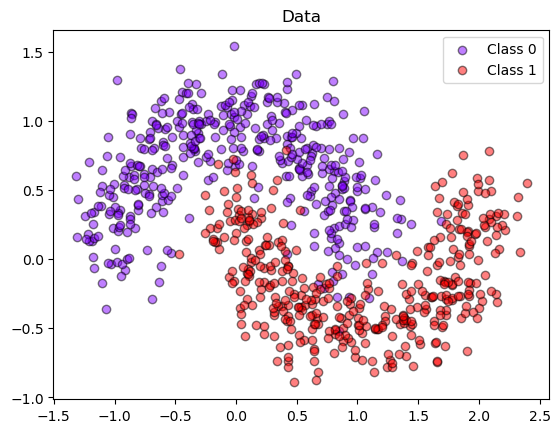

In [12]:
# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  color=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    plt.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm, vmin= 0, vmax=1)
    plt.colorbar()
    CS = plt.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlabel("x")
    plt.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

# Create a 2 moons dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

plot_data(X_train, y_train)

We use the KDMClassModel to train a shallow model that directly apply a KDM inference layer to the raw data. This class assumes a continuos distribution for the input data (i.e. it uses an RBF kernel) and a discrete distribution for the output data. The model is trained using gradient descent with a cross-entropy loss function.

In [8]:
from kdm.models import KDMClassModel

encoded_size = 2
dim_y = 2
encoder = keras.layers.Identity()
n_comp = 10

kdm_model = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1)

# train the classifier
kdm_model.compile(optimizer=optimizers.Adam(learning_rate=5e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])
kdm_model.predict(X_train[:10])
idx = np.random.randint(X_train.shape[0], size=n_comp)
kdm_model.init_components(X_train[idx], 
                          np.eye(2)[y_train[idx]],
                          init_sigma=True)

kdm_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.3566 - sparse_categorical_accuracy: 0.8986
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2541 - sparse_categorical_accuracy: 0.8812
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2039 - sparse_categorical_accuracy: 0.9082
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1860 - sparse_categorical_accuracy: 0.9268
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.9581
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1154 - sparse_categorical_accuracy: 0.9548
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0845 - sparse_categorical_accuracy: 0.9647
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0894 - sparse_categorical_accuracy: 0.9691
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0816 - sparse_categorical_accuracy: 0.9747
Epoch 10/25
25/25 ━━━━━━━

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test loss: 0.1219501718878746
Test accuracy: 0.9649999737739563
Sigma: 0.3602496087551117


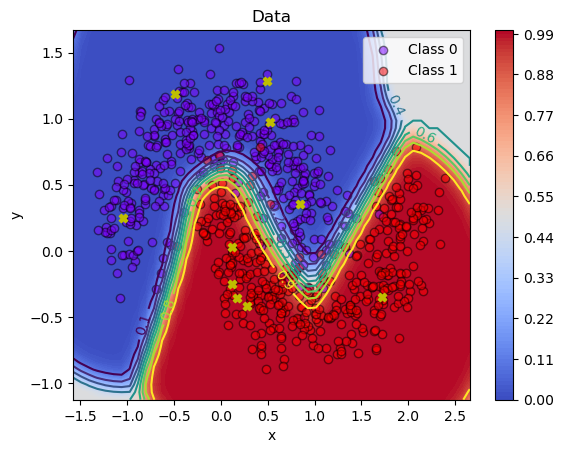

In [13]:
# Plot the decision region
plot_decision_region(X, gen_pred_fun(kdm_model))
plot_data(X_train, y_train)
# plot the prototypes
plt.scatter(kdm_model.kdm.c_x.numpy()[:, 0], kdm_model.kdm.c_x.numpy()[:, 1], c='y', marker='X')
# Evaluate the classifier
score = kdm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(f'Sigma: {kdm_model.kernel.sigma.numpy()}')

The joint KDM components are shown as yellow crosses. Each component has two elements, an $x$ part and a $y$ part. The components are listed below:

In [16]:
weights = np.abs(kdm_model.kdm.c_w.numpy())
weights /= np.sum(weights)
idx = np.argsort(weights)[::-1]
for i in range(kdm_model.n_comp):
    print(f'Component {i}')
    print(f' Weight: {weights[idx[i]]}')
    print(f' x: {kdm_model.kdm.c_x[idx[i]].numpy()}')
    print(f' y: {kdm_model.kdm.c_y[idx[i]].numpy()}')


Component 0
 Weight: 0.21323765814304352
 x: [-1.0476736   0.24539886]
 y: [1. 0.]
Component 1
 Weight: 0.15465201437473297
 x: [-0.4843645  1.1862534]
 y: [1. 0.]
Component 2
 Weight: 0.15375272929668427
 x: [ 1.720752   -0.34786236]
 y: [0. 1.]
Component 3
 Weight: 0.0979297012090683
 x: [ 0.17289317 -0.35332254]
 y: [0. 1.]
Component 4
 Weight: 0.09281834214925766
 x: [ 0.12232476 -0.24943967]
 y: [0. 1.]
Component 5
 Weight: 0.08591920882463455
 x: [0.49697956 1.2875836 ]
 y: [1. 0.]
Component 6
 Weight: 0.07045037299394608
 x: [0.8399815 0.3530574]
 y: [1. 0.]
Component 7
 Weight: 0.05788935720920563
 x: [ 0.28108153 -0.4189899 ]
 y: [0. 1.]
Component 8
 Weight: 0.05745501071214676
 x: [0.11782955 0.02852969]
 y: [0. 1.]
Component 9
 Weight: 0.015895606949925423
 x: [0.524258  0.9745476]
 y: [1. 0.]


### 2.5.2 Non-parametric training

A KDM classification model can be trained in different ways. A seconde alternative is to use a non-parametric strategy, the components of the KDM will correspond to the full training dataset. Each sample will have the same weight. The sigma parameter of the RBF kernel can be provided, calculated based on the distances between samples, or it could be optimized using gradient descent.

In [20]:
n_comp = X_train.shape[0]

kdm_model = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1)

# train the classifier
kdm_model.compile(optimizer=optimizers.Adam(learning_rate=5e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

kdm_model.init_components(X_train, 
                          np.eye(2)[y_train],
                          init_sigma=False)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Test loss: 0.08295877277851105
Test accuracy: 0.9700000286102295
Sigma: 0.10000000149011612


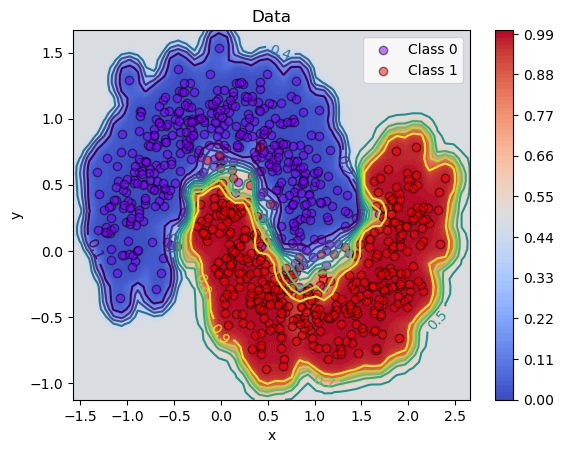

In [21]:
# Plot the decision region
plot_decision_region(X, gen_pred_fun(kdm_model))
plot_data(X_train, y_train)
# Evaluate the classifier
score = kdm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(f'Sigma: {kdm_model.kernel.sigma.numpy()}')

This model is analogous to k-nearest-neighbor classification. The sigma parameter of the RBF kernel can be used to control the smoothness of the decision boundaries, an can be seen as a generalization of the number of neighbors in k-nearest-neighbor classification.

For instance, the following figures show the classification regions with sigma equal to 0.5.

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test loss: 0.1727018505334854
Test accuracy: 0.9599999785423279
Sigma: 0.5


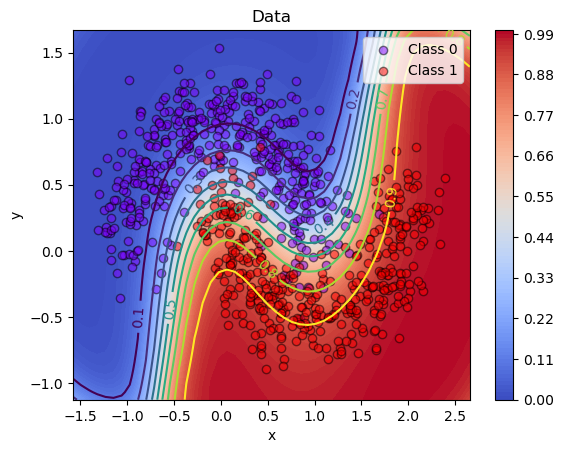

In [22]:
kdm_model.kdm.kernel.sigma.assign(0.5)
# Plot the decision region
plot_decision_region(X, gen_pred_fun(kdm_model))
plot_data(X_train, y_train)
# Evaluate the classifier
score = kdm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(f'Sigma: {kdm_model.kernel.sigma.numpy()}')

### 2.5.3 Generative training

A third alternative to train the model is to train a generative model using maximum likelihood optimization of the joint probability distribution of both the input and output data.

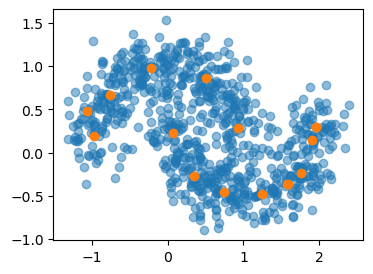

Sigma: 0.30311888456344604


In [31]:
# join X and y using a one-hot encoding for y
Xy_train = np.concatenate((X_train, np.eye(2)[y_train]), axis=1)
Xy_test = np.concatenate((X_test, np.eye(2)[y_test]), axis=1)

dim_x = 2
dim_y = 2
sigma = 0.1
n_comp = 16 

kdm_mle = KDMJointDenEstModel(dim_x=dim_x, dim_y=dim_y, sigma=sigma, n_comp=n_comp)

optimizer = keras.optimizers.Adam(learning_rate=5e-3)
kdm_mle.compile(optimizer=optimizer)
idx = np.random.randint(Xy_train.shape[0], size=n_comp)
kdm_mle.init_components(Xy_train[idx], sigma=sigma) 


kdm_mle.fit(Xy_train, epochs=100, verbose=0, batch_size=100)

# Plot final prototypes
centroids = kdm_mle.kdmproj.c_x.numpy() 
fig = plt.figure(figsize=(4, 3))
plt.scatter(Xy_train[:, 0], Xy_train[:, 1], alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o')
plt.show()

print(f'Sigma: {kdm_mle.kernel_x.sigma.numpy()}')

Compared to the components of the KDM model trained in a discriminative way using gradient descent, this components are evenly distributed in the input space. We can use this components with the classification model to classify new samples.

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Test loss: 0.057535670697689056
Test accuracy: 0.9700000286102295
Sigma: 0.30311888456344604


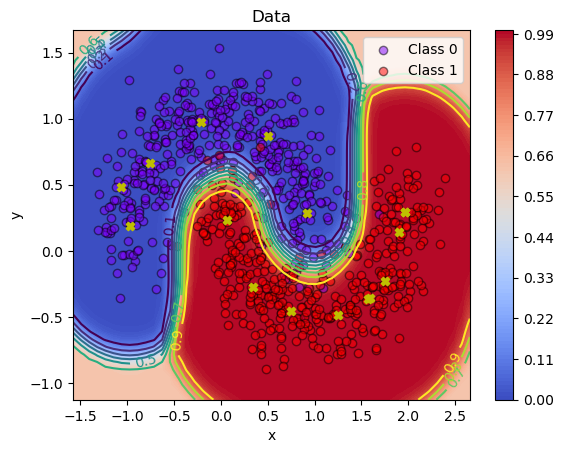

In [33]:
kdm_model = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp)

kdm_model.kdm.c_x.assign(kdm_mle.kdmproj.c_x[:, 0:encoded_size])
kdm_model.kdm.c_y.assign(kdm_mle.kdmproj.c_x[:, encoded_size:])
kdm_model.kdm.c_w.assign(kdm_mle.kdmproj.c_w)
kdm_model.kernel.sigma.assign(kdm_mle.kernel_x.sigma)


kdm_model.compile(optimizer=optimizers.Adam(learning_rate=5e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

# Plot the decision region
plot_decision_region(X, gen_pred_fun(kdm_model))
plot_data(X_train, y_train)
# plot the prototypes
plt.scatter(kdm_model.kdm.c_x.numpy()[:, 0], kdm_model.kdm.c_x.numpy()[:, 1], c='y', marker='X')
# Evaluate the classifier
score = kdm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(f'Sigma: {kdm_model.kernel.sigma.numpy()}')

### 2.5.Conditional generative model

An advantage of using a joint KDM to model the correlation between the input and output data is that the inference can be performed in both directions. Given a $y$ sample, we can use the inference to calculate a probability distribution over the input data. This distribution can be used to generate new samples. This is illustrated in the following figure.

<img src="https://raw.githubusercontent.com/fagonzalezo/kdm/main/kdm_inference_1.jpg" width="500">

We will define a function that given a classification model creates a conditional generation model. 

In [35]:
from kdm.layers import CosineKernelLayer, KDMLayer

def create_generator_model(clf_model):
        inputs_gen = keras.layers.Input(shape=(clf_model.dim_y,))
        kernel_gen = CosineKernelLayer()
        kdm_gen = KDMLayer(kernel=kernel_gen, 
                                   dim_x=clf_model.dim_y, 
                                   dim_y=clf_model.encoded_size, 
                                   n_comp=clf_model.n_comp)
        kdm_gen.c_x.assign(clf_model.kdm.c_y)
        kdm_gen.c_y.assign(clf_model.kdm.c_x)
        kdm_gen.c_w.assign(clf_model.kdm.c_w)
        rho_y_gen = kdm.utils.pure2dm(inputs_gen)
        rho_x_gen = kdm_gen(rho_y_gen)
        gen_model = keras.Model(inputs_gen, rho_x_gen)
        return gen_model

gen_model = create_generator_model(kdm_model)
gen_model.compile()

The generative model receives a distribution over the labels represented by a KDM. The model generates a distribution over the input data represented by a KDM. The following function uses the KDM to create a generative model using Tensorflow Probability.

In [50]:
import tensorflow_probability as tfp
tfd = tfp.distributions

def dm2distrib(dm, sigma):
    '''
    Creates a Gaussian mixture distribution from the components of a density
    matrix with an RBF kernel 
    Arguments:
     dm: tensor of shape (bs, n, d + 1)
     sigma: sigma parameter of the RBF kernel 
    Returns:
     gm: mixture of Gaussian distribution with shape (bs, )
    '''
    w, v = kdm.utils.dm2comp(dm)
    print(w.dtype, v.dtype, sigma.dtype)
    gm = tfd.MixtureSameFamily(reparameterize=True,
            mixture_distribution=tfd.Categorical(
                                    probs=w),
            components_distribution=tfd.Independent( tfd.Normal(
                    loc=v,  # component 2
                    scale=sigma / np.sqrt(2.)),
                    reinterpreted_batch_ndims=1))
    return gm

Now, we can generate new samples using the conditional generative model.

We will define three different probability distributions over the labels and generate new samples for each one.

<dtype: 'float32'> <dtype: 'float32'> float32


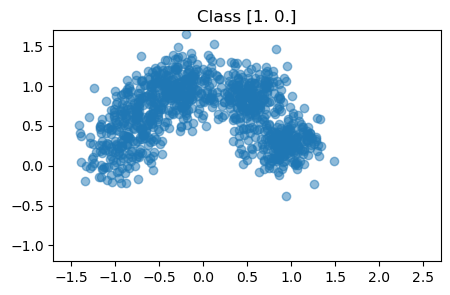

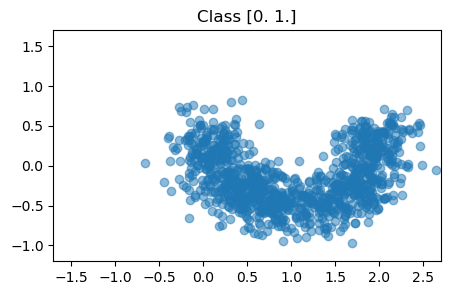

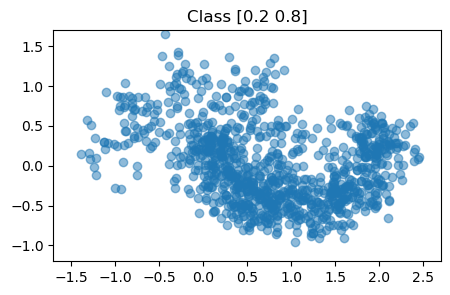

In [64]:
y_distrib = np.array([[1., 0.],
                      [0., 1.],
                      [0.2, 0.8]])

# The components of the corresponding KDMs must be normal vectors that
# when squared correspond to the probabilities
rho_y = np.sqrt(y_distrib)

rho_x = gen_model(rho_y)
gm = dm2distrib(rho_x, kdm_model.kernel.sigma)
for i in range(len(rho_y)):
    sample = gm[i].sample(1000)
    plt.figure(figsize=(5, 3))
    plt.title(f'Class {y_distrib[i]}')
    plt.xlim(-1.7, 2.7)
    plt.ylim(-1.2, 1.7)    
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5)
    plt.show()